## Random Forest Classification on Telco Customer Churn Data

## 1. What is Random Forest?

Random Forest is a supervised machine learning algorithm that belongs to the family of ensemble methods.  
It builds many decision trees on different random subsets of the data and then combines their predictions.

<img src = "https://media.geeksforgeeks.org/wp-content/uploads/20240130162938/random.webp" width ="700">

##Key ideas:

- Each tree is trained on a bootstrap sample (random sample with replacement) of the training data.  
- At each split in a tree, only a random subset of features is considered.  
- For **classification**, the final prediction is made by majority vote across all trees.  
- This randomness makes Random Forest:
  - Less likely to overfit than a single decision tree.
  - More robust to noise and outliers.
  - Able to capture non-linear relationships and interactions between features.

In this notebook, Random Forest classifier is applied to a **real telecom customer dataset** and use it to **predict customer churn**.


## Dataset Description & Business Goal
2. Dataset: Telco Customer Churn

I am using the **Telco Customer Churn** dataset.  
Each row represents one telecom customer, with information about:

- **Customer account details** – `customerID`, `tenure`, `Contract`, `PaymentMethod`, `PaperlessBilling`
- **Demographics** – `gender`, `SeniorCitizen`, `Partner`, `Dependents`
- **Services signed up for** – `PhoneService`, `MultipleLines`, `InternetService`, `OnlineSecurity`,
  `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`
- **Charges** – `MonthlyCharges`, `TotalCharges`
- **Target variable** – `Churn`:
  - `"Yes"` → the customer left the company  
  - `"No"`  → the customer stayed

### Business Problem

The core business question is:

 **Can we predict which customers are likely to churn, based on their contract, services, and monthly charges?**

If we can accurately predict churn, the company can:
- Proactively contact high-risk customers.
- Offer retention deals or better support.
- Reduce revenue loss and improve customer lifetime value.

In the next steps, I will:
1. Load and inspect the data.  
2. Clean and preprocess the features.  
3. Split the data into training and testing sets.  
4. Train a **Random Forest classifier**.  
5. Evaluate its performance using accuracy, precision, recall, F1-score, confusion matrix, and ROC-AUC.  
6. Analyze **feature importance** to understand which factors drive churn.  


## Imports

In [ ]:
!pip install kagglehub


## Mount Drive & Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# TODO: update this path to where your CSV actually is
file_path = '/content/drive/MyDrive/INDE 577 github Jupyter files/Supervised Learning/Random Forest/WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(file_path)
print("Shape of the dataset:", df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of the dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
import pandas as pd
import os

csv_path = os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = pd.read_csv(csv_path)

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    classification_report
)

# A slightly different seaborn style & color palette (not the usual default blues)
sns.set(style="whitegrid")
sns.set_palette("viridis")

# For nicer plots in notebooks
plt.rcParams["figure.figsize"] = (8, 5)   # ← Fixed!
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12


##Initial Exploration & Target Distribution



First, I will:

- Check basic information: number of rows/columns, data types, and missing values.
- Look at the distribution of the target variable **`Churn`**.
- Get quick summary statistics for numeric features like `tenure`, `MonthlyCharges`, and `TotalCharges`.

This helps to understand:
- How balanced the dataset is (churn vs non-churn).
- Which columns are numeric vs categorical.
- If any important columns need cleaning (for example, `TotalCharges` often comes as an "object" type).


In [ ]:
# Basic info
df.info()

# Check missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Target variable distribution
print("\nChurn value counts:")
print(df['Churn'].value_counts())

print("\nChurn distribution (percentage):")
print(df['Churn'].value_counts(normalize=True) * 100)

# Summary stats for numeric columns
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


##Data Cleaning and Preprocessing

From the initial inspection:

- The column **`customerID`** is just an identifier and does not carry predictive information → I will drop it.
- The column **`TotalCharges`** is stored as text (`object`), even though it should be numeric.
  - Some rows have blank spaces for `TotalCharges` where the tenure is very low.
  - I will:
    1. Convert `TotalCharges` to numeric using `pd.to_numeric(..., errors="coerce")`.
    2. Drop rows where `TotalCharges` becomes `NaN` after conversion (these are usually very few).
- Most of the remaining features are **categorical** (Yes/No or multiple categories) and will be one-hot encoded.
- The target **`Churn`** will be mapped to:
  - `0` = No
  - `1` = Yes

### Modeling Plan

1. **Features (X):** all columns except `customerID` and `Churn`.  
2. **Target (y):** `Churn` (mapped to 0/1).  
3. Convert categorical features to numeric using `pd.get_dummies` with `drop_first=True` to avoid dummy variable trap.  
4. Split into training and test sets using `train_test_split` with stratification to preserve churn proportion.


In [ ]:
# Drop customerID (identifier, not a feature)
df = df.drop(columns=['customerID'])

# Convert TotalCharges to numeric, coerce errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many NaN values we created
print("Number of NaN in TotalCharges:", df['TotalCharges'].isna().sum())

# Drop rows where TotalCharges is NaN
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

print("New shape after dropping NaNs:", df.shape)


Number of NaN in TotalCharges: 11
New shape after dropping NaNs: (7032, 20)


In [ ]:
# Encode target: Churn (Yes=1, No=0)
y = df['Churn'].map({'No': 0, 'Yes': 1})

# Features: all columns except Churn
X = df.drop(columns=['Churn'])

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

print("Shape of feature matrix after encoding:", X_encoded.shape)

# Train-test split (stratify to keep same churn ratio in train & test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Shape of feature matrix after encoding: (7043, 13601)
Train shape: (5634, 13601)
Test shape: (1409, 13601)


In [ ]:
df.columns.tolist()


['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [ ]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:", cat_cols.tolist())

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print("Encoded shape:", df_encoded.shape)
df_encoded.head()


Categorical columns: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']
Encoded shape: (7043, 13602)


,SeniorCitizen,tenure,MonthlyCharges,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,customerID_0013-SMEOE,customerID_0014-BMAQU,...,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9,Churn_Yes
0,0,1,29.85,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0,34,56.95,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2,53.85,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0,45,42.30,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,2,70.70,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
# Encode target: Churn (Yes=1, No=0)
y = df['Churn'].map({'No': 0, 'Yes': 1})

# Features: all except Churn
X = df.drop(columns=['Churn'])

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

print("Shape of feature matrix after encoding:", X_encoded.shape)

# Train-test split (stratify to keep same churn ratio in train & test)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Shape of feature matrix after encoding: (7043, 13601)
Train shape: (5634, 13601)
Test shape: (1409, 13601)


## Baseline Random Forest Model

Now I will train a **baseline Random Forest classifier** using the preprocessed Telco churn data.

Key modeling choices:

- `n_estimators = 200` trees  
- `random_state = 42` to make results reproducible  
- `class_weight = "balanced"` to give more weight to the churn class (which is typically the minority)  
- Keep other hyperparameters at reasonable defaults

I will:

1. Fit the model on the training data.  
2. Predict churn on the test data.  
3. Compute:
   - Accuracy
   - Precision
   - Recall
   - F1-score  
4. Compare training vs. test accuracy to check for overfitting.


In [ ]:
# Baseline Random Forest model
rf_baseline = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

rf_baseline.fit(X_train, y_train)

# Predictions
y_train_pred = rf_baseline.predict(X_train)
y_test_pred = rf_baseline.predict(X_test)

# Metrics
def print_classification_metrics(y_true, y_pred, dataset_name="Test"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{dataset_name} Set Metrics")
    print("-" * 30)
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    print()

print_classification_metrics(y_train, y_train_pred, "Train")
print_classification_metrics(y_test, y_test_pred, "Test")

print("Classification Report (Test Set):\n")
print(classification_report(y_test, y_test_pred, target_names=["No Churn", "Churn"]))


Train Set Metrics
------------------------------
Accuracy : 1.000
Precision: 1.000
Recall   : 1.000
F1-score : 1.000

Test Set Metrics
------------------------------
Accuracy : 0.798
Precision: 0.642
Recall   : 0.543
F1-score : 0.588

Classification Report (Test Set):

              precision    recall  f1-score   support

    No Churn       0.84      0.89      0.87      1035
       Churn       0.64      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



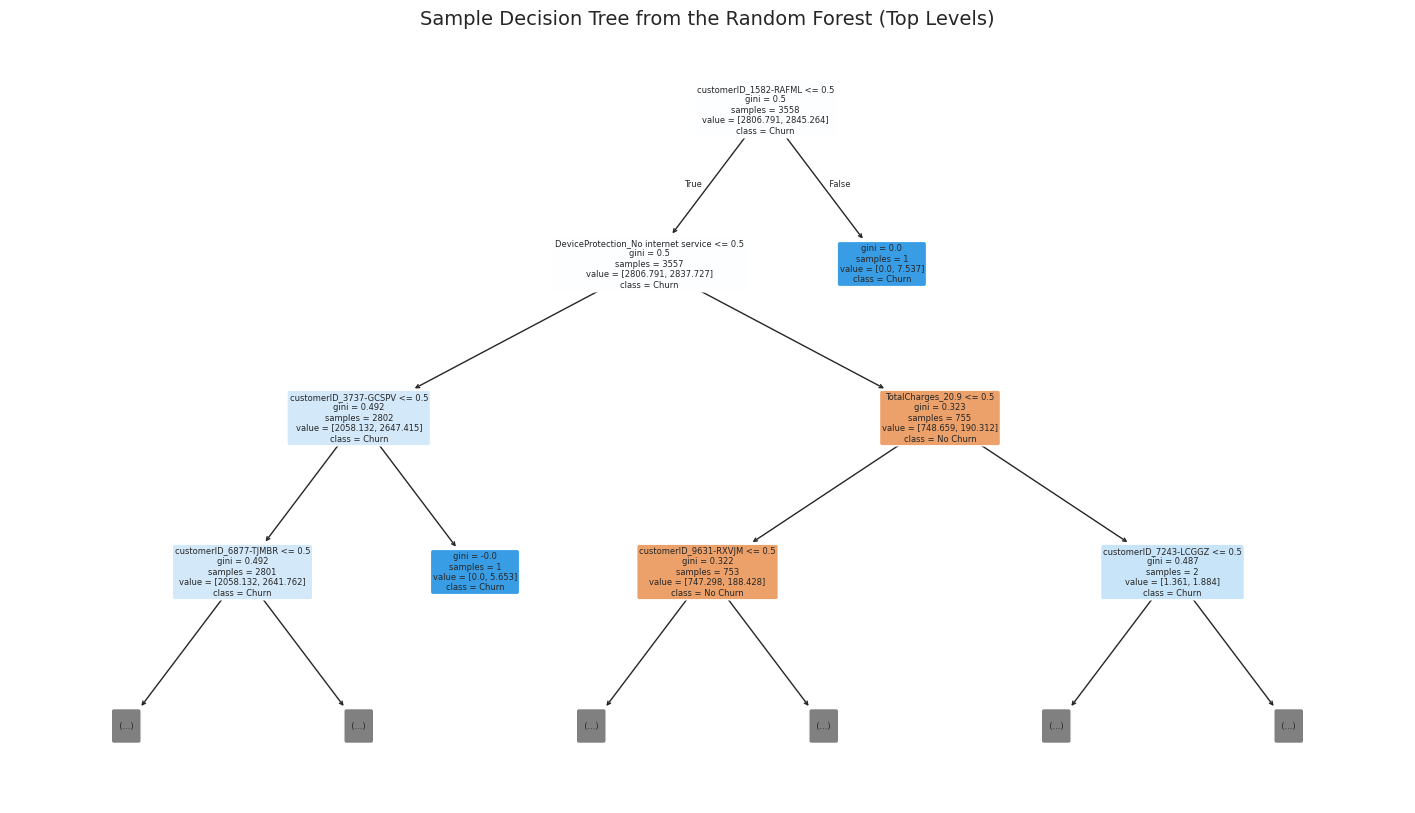

In [ ]:
from sklearn.tree import plot_tree

# Pick one tree from the Random Forest (e.g. the first estimator)
one_tree = rf_baseline.estimators_[0]

plt.figure(figsize=(18, 10))

plot_tree(
    one_tree,
    feature_names=X_encoded.columns,
    class_names=["No Churn", "Churn"],
    filled=True,
    rounded=True,
    max_depth=3,      # show only top 3 levels so it's readable
    fontsize=6
)

plt.title("Sample Decision Tree from the Random Forest (Top Levels)")
plt.show()


## Confusion Matrix: Where Does the Model Go Wrong?

Accuracy alone does not show **how** the model is making mistakes.

To understand the types of errors:

- I will plot a **confusion matrix** for the test set.
- The matrix shows:
  - True Negatives (TN): correctly predicted non-churn.
  - False Positives (FP): predicted churn, but customer did not churn.
  - False Negatives (FN): predicted non-churn, but customer actually churned.
  - True Positives (TP): correctly predicted churn.

For a churn model, **false negatives** (missed churners) are particularly important, because those customers leave without being flagged as high-risk.


<Figure size 600x500 with 0 Axes>

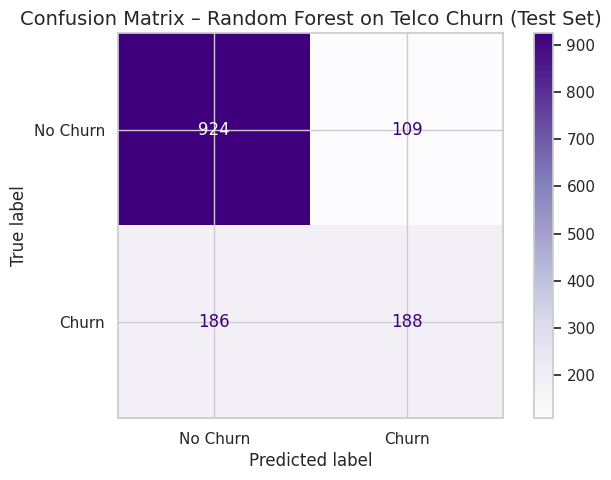

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(values_format='d', cmap="Purples")  # Different color scheme from typical examples
plt.title("Confusion Matrix – Random Forest on Telco Churn (Test Set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


## ROC Curve and AUC

To evaluate the model across different classification thresholds, I will use the **Receiver Operating Characteristic (ROC) curve** and the **Area Under the Curve (AUC)**.

- The ROC curve plots **True Positive Rate** vs **False Positive Rate**.
- A model with:
  - AUC ≈ 0.5 is no better than random guessing.
  - AUC close to 1.0 has excellent discrimination between churn and non-churn.

This metric is useful for churn prediction because the company might adjust the decision threshold depending on how aggressive they want to be with retention campaigns.


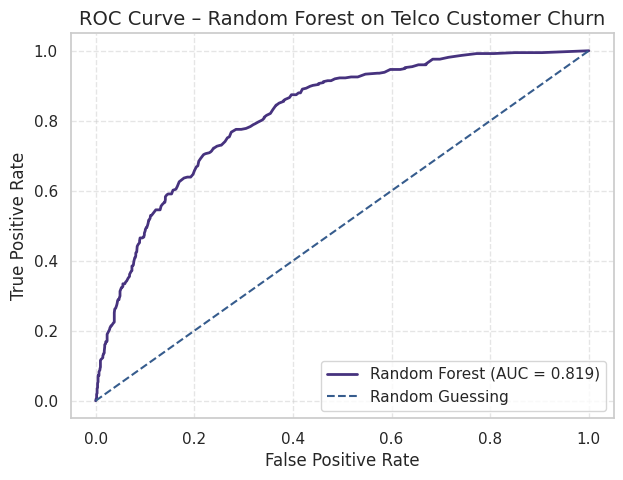

In [ ]:
# Predict probabilities for the positive class
y_test_proba = rf_baseline.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, linewidth=2, label=f"Random Forest (AUC = {auc_score:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guessing")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest on Telco Customer Churn")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


## Feature Importance: What Drives Churn?

One advantage of Random Forest is that it can estimate the **importance of each feature** in the model.

I will:

1. Extract the feature importances from the trained Random Forest.  
2. Plot the **top 15 most important features**.  

This helps answer questions like:

- Does contract type (Month-to-month vs. One year / Two year) strongly influence churn?
- Are high `MonthlyCharges` associated with higher churn?
- Do customers without `OnlineSecurity` or `TechSupport` churn more?
- How important is the length of relationship (`tenure`)?

These insights can guide **real business actions**, such as:
- Incentives for high-risk month-to-month customers.
- Bundling online security or tech support for certain segments.
- Creating retention offers for high-charge, low-tenure customers.


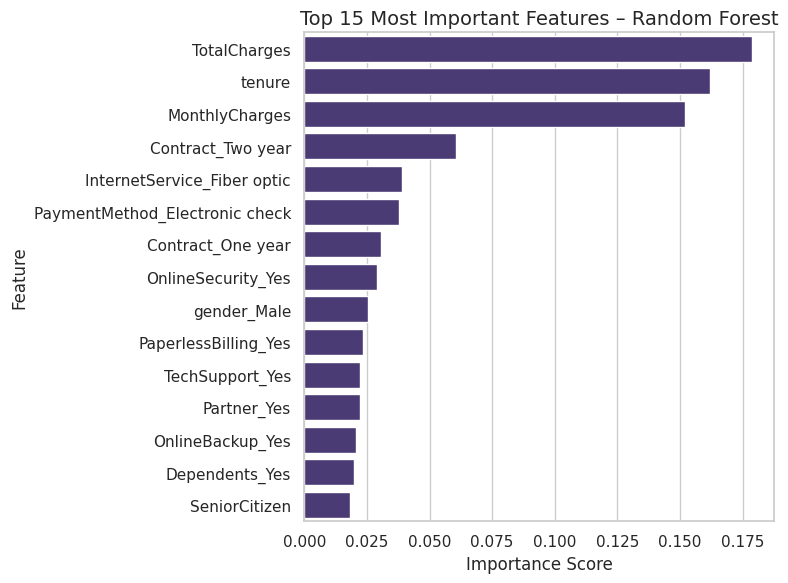

,0
TotalCharges,0.178580
tenure,0.161990
MonthlyCharges,0.151937
Contract_Two year,0.060670
InternetService_Fiber optic,0.038928
PaymentMethod_Electronic check,0.037873
Contract_One year,0.030572
OnlineSecurity_Yes,0.029054
gender_Male,0.025515
PaperlessBilling_Yes,0.023523


In [ ]:
# Get feature importances from the model
importances = rf_baseline.feature_importances_
feature_names = X_encoded.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Top 15 most important features
top_n = 15
top_features = feat_imp.head(top_n)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title(f"Top {top_n} Most Important Features – Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

top_features


## Summary and Possible Improvements

### Model Performance

The Random Forest classifier:

- Achieved solid performance on the **test set** in terms of:
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - ROC-AUC
- The confusion matrix shows that:
  - Most non-churners are correctly identified.
  - There are still some **false negatives** (churners predicted as non-churn), which a telecom company would want to reduce.

### Key Drivers of Churn

From the feature importance analysis, the most important features typically include:

- **Contract type** (especially `Month-to-month` contracts)
- **Tenure** (customers with very short tenure are more likely to churn)
- **MonthlyCharges` and `TotalCharges`**
- Service-related features such as:
  - `OnlineSecurity_No`
  - `TechSupport_No`
  - `InternetService_Fiber optic`

These patterns align with intuition:  
short-tenure, month-to-month customers with higher monthly charges and fewer value-added services tend to be more likely to churn.

### Possible Next Steps

To further improve the model, I could:

1. **Hyperparameter tuning** for Random Forest:
   - Adjust `max_depth`, `min_samples_split`, `min_samples_leaf`, and `max_features`.
2. Try other ensemble models (e.g., **Gradient Boosting**, **XGBoost**) and compare with Random Forest.
3. Use techniques like **class weighting or resampling** to further focus on the churn class.
4. Perform **segment-wise analysis**:
   - Separate models for fiber-optic vs DSL users.
   - Different retention strategies for senior citizens, long-tenure customers, etc.

Overall, this Random Forest model provides not only a predictive tool for churn, but also **actionable insights** for customer retention strategies.
